In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import sys
import os
import glob
import datetime
from scipy import stats
import gsw
import matplotlib
from itertools import groupby
import random
from AutoBOD_processing import calc_o2_conc, calc_airsat, bottle_add_data, standardize_Nobs, datetime_from_date_hour, autobod_processing
matplotlib.rcParams.update({'font.size': 15})

### AutoBOD processing

Whenever the AutoBOD is reset (turned off and on again), it initializes from a preset date. For the Calypso 2022 cruise, that was Jan. 1, 2022. We can get a relative elapsed time by subtracting this start date from the date recorded by the AutoBOD

In [108]:
autoBOD_start_date = datetime.datetime(2022, 1, 1)

We need to provide the directory where all the logs from the AutoBOD are stored. In addition, we provide the location of a CSV that connects the AutoBOD log data and locations of all bottles to the relevant metadata. An example CSV is provided in the GitHub repository. 

In [109]:
# Location of log files from AutoBOD

log_dir = '../logs/AutoBOD_logs/'

# Location of metadata CSV
log_sheet = pd.read_excel('../logs/AutoBOD_digital_log_sheet_091622.xlsx', sheet_name='autobod_log_sheet')

In [110]:
master_ds = autobod_processing(log_dir, log_sheet, autoBOD_start_date, logging_on=True)

C001_021822_autoBOD-1.log
C001_021822_autoBOD.log
C002_021922_autoBOD.log
Run003_022122_autoBOD.log
Run004_022122_autoBOD.log
Run005_022122_autoBOD.log
Run006_022222_autoBOD.log
Run007_022322_autoBOD.log
Run008_022322_autoBOD.log
Run009_022322_autoBOD.log
Run010_022322_autoBOD.log
Run011_022322_autoBOD.log
Run012_022322_autoBOD.log
Run013_022422_autoBOD.log
Run014_022422_autoBOD.log
Run015_022522_autoBOD.log
Run016_022522_autoBOD.log
Run017_022522_autoBOD.log
Run018_022622_autoBOD.log
Run019_022622_autoBOD.log
Run020_022622_autoBOD.log
Run021_022622_autoBOD.log
Run022_022722_autoBOD.log
Run023_022722_autoBOD.log
Run024_022722_autoBOD.log
Run025_022722_autoBOD.log
Run026_022822_autoBOD.log
Run027_022822_autoBOD.log
Run028_022822_autoBOD.log
Run029_022822_autoBOD.log
Run030_030122_autoBOD.log
Run031_030122_autoBOD.log
Run032_030122_autoBOD.log
Run033_030122_autoBOD.log
Run034_030222_autoBOD.log
Run035_030322_autoBOD.log
Run036_030322_autoBOD.log
Run037_030322_autoBOD.log
Run038_030322_au

In [77]:
#master_ds.to_netcdf('../autoBOD_logs_consolidated.nc')

### Now that we have the log files consolidated into one netCDF, we want to calculate the oxygen concentration.
This will range from straightforward to complicated, depending on how we deal with the temperature. It is very noisy, and that error is propagated multiple times, first in the calculation of the percent saturation of oxygen, then in the actual concentration of oxygen in freshwater (which relies on temperature) and then in the salinity correction to account for different solubility of seawater vs. freshwater. 

However, the signal we are interested in is in the oxygen and not the temperature, so it makes the most sense to average the temperature observations over a single 10-measurement period, and then use that to calculate the oxygen concentration from percent saturation. 

For thoroughness, I'm calculating in three different ways: 1) by averaging the 10 measurements of temperature and using that to calculate both percent saturation and oxygen concentration (`temp_averaged_percent_sat`) 2) by using the individual 10 observations of temperature to calculate percent saturation but the averaged observations to calculate oxygen saturation from the percent saturation (`temp_averaged_oxygen_conc`) and 3) by using the individual observations for both calculations (`temp_original_obs`)

In [111]:
### Prepare xarray dataset for additional data fields
empty_arr = np.empty((master_ds.dims['N_bottles'], master_ds.dims['N_obs']))
empty_arr[:] = np.nan
master_ds['O2_conc_temp_averaged_percent_sat'] = (('N_bottles', 'N_obs'), empty_arr)
master_ds['O2_conc_temp_averaged_oxygen_conc'] = (('N_bottles', 'N_obs'), empty_arr)
master_ds['O2_conc_temp_original_obs'] = (('N_bottles', 'N_obs'), empty_arr)

In [112]:
# def calculate_nobs(ds, n_msmts=10):
#     ### Calculate number of unique sets of N measurements
#     nobs = len([key for key, _group in groupby(ds.measurement_number.values.flatten()[nan_ind])])
#     ## Sometimes the measurement number gets repeated during the concatenation — if that's the case, double-check and add
#     obs_list = np.array([len(list(group)) for key, group in groupby(ds.measurement_number.values.flatten()[nan_ind])])
#     nobs += np.sum(obs_list > n_msmts) 
#     return nobs

In [113]:
def pad_obs(sample_arr, var_arr, nobs, n_msmts=10):
    ### Takes an array with sample numbers (i.e. [1, 2, 3, ... 10, 1, 2, ... 10]) and figures out whether there are
    ### any skips in the iteration and pads/fills them in with NaNs in the accompanying var_array
    
    ### Pad the sample array with the number of "missing" observations to make it the right length
    sample_arr_padded = np.pad(sample_arr, (0, nobs*n_msmts - len(sample_arr)))
    ### where does the expected array not match the actual sample array?
    expected_sample_arr = np.tile(np.arange(1, n_msmts+1), nobs)
    mismatched_inds = np.argwhere(expected_sample_arr != sample_arr_padded)

    while len(mismatched_inds) > 0:
        sample_arr = np.insert(sample_arr, mismatched_inds[0], expected_sample_arr[mismatched_inds[0]])
        var_arr = np.insert(var_arr, mismatched_inds[0], np.nan)

        #Recalculate amount of mismatch
        sample_arr_padded = np.pad(sample_arr, (0, nobs*n_msmts - len(sample_arr)))
        mismatched_inds = np.argwhere(expected_sample_arr != sample_arr_padded)
        
    return sample_arr, var_arr

In [114]:
n_msmts = 10 #Here, the AutoBOD takes 10 measurements at a time, but it would be possible to have more/fewer

In [115]:
# bid = 'C10N18_1'
# b_ds = master_ds.isel(N_bottles = master_ds.Bottle_ID == bid)

In [116]:
# b_ds.SA

In [117]:
b_ds

<xarray.Dataset>
Dimensions:                            (N_bottles: 1, N_obs: 18692)
Coordinates:
    Bottle_ID                          (N_bottles) object 'Flowthrough_2'
Dimensions without coordinates: N_bottles, N_obs
Data variables: (12/26)
    Amplitude                          (N_bottles, N_obs) float64 3.936e+03 ....
    Phase                              (N_bottles, N_obs) float64 28.81 ... nan
    Optode_Calculated_O2               (N_bottles, N_obs) float64 1.684e+03 ....
    Error                              (N_bottles, N_obs) float64 1.0 ... nan
    Encoder                            (N_bottles, N_obs) float64 1.312e+04 ....
    Bottle                             (N_bottles, N_obs) float64 3.0 ... nan
    ...                                 ...
    SA                                 (N_bottles) float64 nan
    CT                                 (N_bottles) float64 nan
    Cast_Niskin                        (N_bottles) object 'CNANNA'
    O2_conc_temp_averaged_percent_sat  (N_bottles, N_obs) float64 284.9 ... nan
    O2_conc_temp_averaged_oxygen_conc  (N_bottles, N_obs) float64 285.9 ... nan
    O2_conc_temp_original_obs          (N_bottles, N_obs) float64 287.2 ... nan

In [118]:
bids = master_ds.Bottle_ID.values

In [120]:
for bid in bids:
    b_ds = master_ds.isel(N_bottles = master_ds.Bottle_ID == bid)
    nan_ind = ~np.isnan(b_ds.Sample.values.flatten())
    oxy_sample = b_ds.Sample.values.flatten()[nan_ind]
    oxy_temp = b_ds.IRBotT.values.flatten()[nan_ind]
    oxy_phase = b_ds.Phase.values.flatten()[nan_ind]
    oxy_time = b_ds.UTC_datetime.values.flatten()[nan_ind].astype('float')/(1e9*60) #in minutes
    
    run = b_ds.to_dataframe()
    run = run.dropna(subset = ['Phase'])
    msmts = (((run['Sample'] - run['Sample'].shift(1)) <= 0).cumsum() + 1).values
    nobs = np.nanmax(msmts)
    
    oxy_sample_padded, oxy_temp_padded = pad_obs(oxy_sample, oxy_temp, nobs)
    
    ### Check if padded array contains the right number of measurements
    if np.sum(np.diff(np.reshape(oxy_sample_padded, (len(oxy_sample_padded)//n_msmts, n_msmts)), axis=0)) != 0:
        print("Sample array may not contain the correct arrangement of measurements")

    oxy_temp_arr = np.reshape(oxy_temp_padded, (len(oxy_temp_padded)//n_msmts, n_msmts))
    ### Want to get the count of observations/samples in each measurement that the AutoBOD makes
#     msmts = b_ds.measurement_number.values.flatten()[nan_ind]
    reps = np.array([ sum( 1 for _ in group ) for key, group in groupby( msmts )])
    tiled_avg_temp = np.repeat(np.nanmean(oxy_temp_arr, axis=1), reps)
    
    # Create empty array of the correct length and only fill it where this particular bottle had observations
    full_arr = np.zeros(nan_ind.shape)
    full_arr[:] = np.nan
    
    absolute_sal = b_ds.SA.values[0]
    
    if np.isnan(absolute_sal): 
        # i.e. for blanks, still want to be able to calculate oxygen
        absolute_sal = 0
    
    temp_averaged_percent_sat = calc_o2_conc(calc_airsat(oxy_phase, tiled_avg_temp), tiled_avg_temp, absolute_sal)
    full_arr[nan_ind] = temp_averaged_percent_sat
    master_ds['O2_conc_temp_averaged_percent_sat'] = xr.where(master_ds.Bottle_ID == bid, 
                                                              full_arr, master_ds.O2_conc_temp_averaged_percent_sat)

    temp_averaged_oxygen_conc = calc_o2_conc(calc_airsat(oxy_phase, oxy_temp), tiled_avg_temp, absolute_sal)
    full_arr[nan_ind] = temp_averaged_oxygen_conc
    master_ds['O2_conc_temp_averaged_oxygen_conc'] = xr.where(master_ds.Bottle_ID == bid, 
                                                              full_arr, master_ds.O2_conc_temp_averaged_oxygen_conc)

    temp_original_obs = calc_o2_conc(calc_airsat(oxy_phase, oxy_temp), oxy_temp, absolute_sal)
    full_arr[nan_ind] = temp_original_obs
    master_ds['O2_conc_temp_original_obs'] = xr.where(master_ds.Bottle_ID == bid, 
                                                              full_arr, master_ds.O2_conc_temp_original_obs)


In [121]:
bid = 'Flowthrough_2'
b_ds = master_ds.isel(N_bottles = master_ds.Bottle_ID == bid)

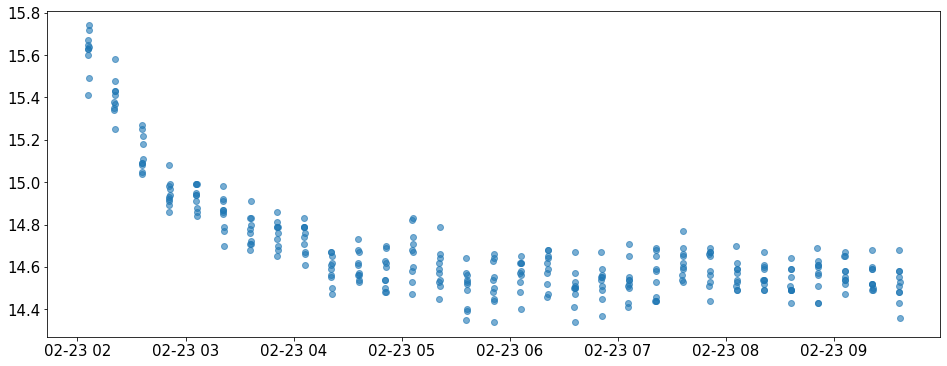

In [122]:
plt.figure(figsize=(16,6))
plt.scatter(b_ds.UTC_datetime, b_ds.IRBotT.values[0], alpha=0.6);
#plt.scatter(b_ds.UTC_datetime, b_ds.O2_conc_temp_original_obs.values[0], alpha=0.25);
#plt.plot(b_ds.IRBotT.values[0], alpha=0.25);
#plt.gca().twinx().plot(b_ds.Optode_Calculated_O2.values[0], alpha=0.25);


In [123]:
elapsed_time = b_ds.UTC_datetime.values.astype('float') - np.nanmin(b_ds.UTC_datetime.values).astype('float')
elapsed_time = elapsed_time/1e9/60/60

Text(0, 0.5, 'Oxygen concentration ($\\mu$mol/L)')

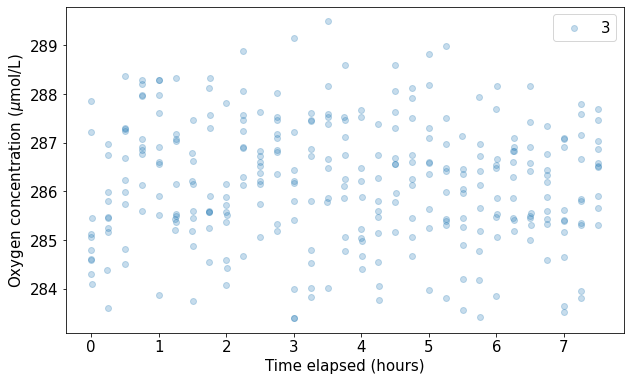

In [124]:
plt.figure(figsize=(10,6))
# plt.scatter(elapsed_time, b_ds.O2_conc_temp_averaged_percent_sat.values[0], 
#             alpha=0.6, label='1');
#plt.scatter(elapsed_time, b_ds.O2_conc_temp_averaged_oxygen_conc.values[0], alpha=0.5, label='2');
plt.scatter(elapsed_time, b_ds.O2_conc_temp_original_obs.values[0], alpha=0.25, label='3');
#plt.plot(b_ds.IRBotT.values[0], alpha=0.25);
#plt.gca().twinx().plot(b_ds.Optode_Calculated_O2.values[0], alpha=0.25);
plt.legend()
#plt.ylim(202, 212.5)
plt.xlabel('Time elapsed (hours)')
plt.ylabel(r'Oxygen concentration ($\mu$mol/L)')

In [134]:
master_ds.to_netcdf('../autoBOD_processed_oxygen.nc')

In [126]:
nan_ind = ~np.isnan(b_ds.Sample.values.flatten())
oxy_ts = b_ds.O2_conc_temp_averaged_percent_sat.values.flatten()[nan_ind]
oxy_time = b_ds.UTC_datetime.values.flatten()[nan_ind].astype('float')/(1e9*60) #in minutes

In [127]:
nobs = len(oxy_ts)
rands = [np.random.randint(nobs), np.random.randint(nobs)]

In [128]:
# Check that the two are more than an hour apart

if np.abs(oxy_time[rands[0]] - oxy_time[rands[1]])/60 >= 1:
    print((oxy_ts[rands[0]] - oxy_ts[rands[1]])/(oxy_time[rands[0]] - oxy_time[rands[1]]))

-0.004757275884769858


In [129]:
slopes = []
for i in range(10000):
    rands = [np.random.randint(nobs), np.random.randint(nobs)]
    if np.abs(oxy_time[rands[0]] - oxy_time[rands[1]])/300 >= 1:
        slopes.append((oxy_ts[rands[0]] - oxy_ts[rands[1]])/(oxy_time[rands[0]] - oxy_time[rands[1]]))

In [130]:
slopes = []
delta_ts = 0
for i in range(10000):
    rands = [np.random.randint(nobs), np.random.randint(nobs)]
    delta_t = np.abs(oxy_time[rands[0]] - oxy_time[rands[1]])
    slopes.append(delta_t*(oxy_ts[rands[0]] - oxy_ts[rands[1]])/(oxy_time[rands[0]] - oxy_time[rands[1]]))
    delta_ts += delta_t

/Users/katyabbott/miniconda3/envs/argo/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [131]:
np.array(slopes)*60*24/delta_ts

array([ 0.00131246, -0.00050959,  0.00069221, ..., -0.00111701,
       -0.00151238,  0.00044281])

(-5.0, 5.0)

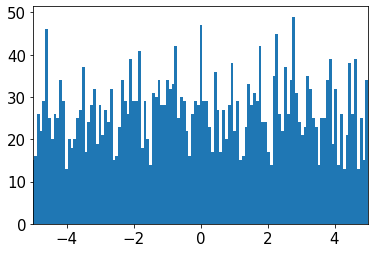

In [132]:
plt.hist(np.array(slopes)*60*24/delta_ts*10000, bins=1000);
plt.xlim([-5, 5])

In [133]:
mu, sigma = np.nanmean(np.array(slopes)*24*60*10000/delta_ts), np.nanstd(np.array(slopes)*24*60*10000/delta_ts)
stats.norm.interval(0.95, loc=mu, scale=sigma)

(-23.745717714124158, 22.51077040521555)

### Plotting temperature and oxygen variability

In [276]:
bid_ds = master_ds.isel(N_bottles = master_ds.Bottle_ID=='C8N15_1')

In [277]:
bid_df = bid_ds.to_dataframe()
bid_df = bid_df.dropna()

In [278]:
bid_df['measurement_number'] = ((bid_df['Sample'] - bid_df['Sample'].shift(1)) < 0).cumsum() + 1

In [279]:
bid_df = bid_df.sort_values(by='UTC_datetime')

In [280]:
bid_df['elapsed_time_minutes'] = bid_df.UTC_datetime.values.astype('float')/1e9/60 - np.nanmin(
            bid_df.UTC_datetime.values.astype('float')/1e9/60)


In [281]:
stats_df = bid_df.groupby('measurement_number').agg({'IRBotT': [np.nanmean, np.nanstd], 
                                'Phase': [np.nanmean, np.nanstd], 'elapsed_time_minutes': 'mean'})

Text(0, 0.5, 'Bottle temperature (deg C)')

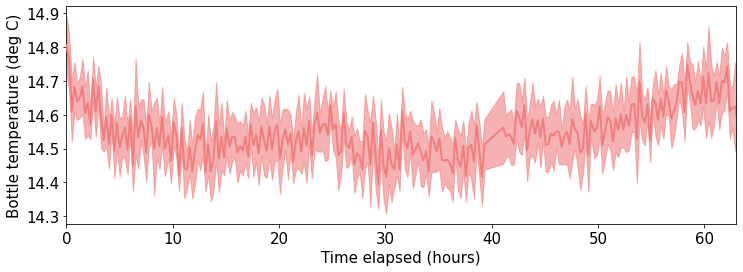

In [282]:
plt.figure(figsize=(12, 4))
plt.plot(stats_df['elapsed_time_minutes']/60, stats_df['IRBotT'].nanmean, zorder=10, linewidth=2, color='lightcoral')
plt.fill_between(stats_df['elapsed_time_minutes'].values.flatten()/60, 
                 stats_df['IRBotT'].nanmean - stats_df['IRBotT'].nanstd,
                stats_df['IRBotT'].nanmean + stats_df['IRBotT'].nanstd, alpha=0.6, color='lightcoral')
plt.xlabel('Time elapsed (hours)')
plt.xlim(0, 63)
plt.ylabel('Bottle temperature (deg C)')

Text(0, 0.5, 'Phase')

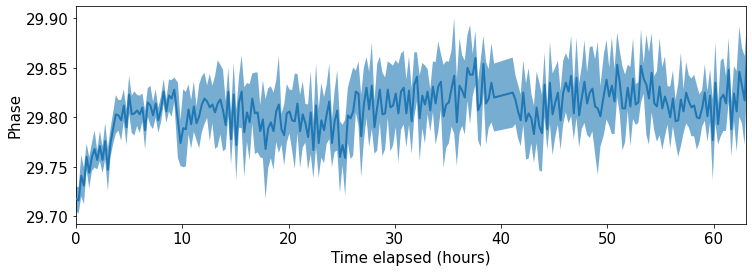

In [283]:
plt.figure(figsize=(12, 4))
plt.plot(stats_df['elapsed_time_minutes']/60, stats_df['Phase'].nanmean, zorder=10, linewidth=2)
plt.fill_between(stats_df['elapsed_time_minutes'].values.flatten()/60, 
                 stats_df['Phase'].nanmean - stats_df['Phase'].nanstd,
                stats_df['Phase'].nanmean + stats_df['Phase'].nanstd, alpha=0.6)
plt.xlabel('Time elapsed (hours)')
plt.xlim(0, 63)
plt.ylabel('Phase')

In [187]:
stats_df = bid_df.groupby('measurement_number').agg({'O2_conc_temp_averaged_oxygen_conc': [np.nanmean, np.nanstd], 
                                'O2_conc_temp_averaged_percent_sat': [np.nanmean, np.nanstd],
                                    'O2_conc_temp_original_obs': [np.nanmean, np.nanstd],
                                                     'elapsed_time_minutes': 'mean'})

Text(0, 0.5, 'O2_sat')

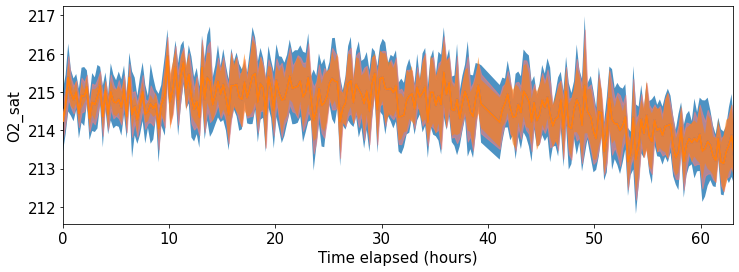

In [192]:
plt.figure(figsize=(12, 4))

plt.plot(stats_df['elapsed_time_minutes']/60, stats_df['O2_conc_temp_original_obs'].nanmean, 
         zorder=10, linewidth=2)
plt.fill_between(stats_df['elapsed_time_minutes'].values.flatten()/60, 
            stats_df['O2_conc_temp_original_obs'].nanmean - stats_df['O2_conc_temp_original_obs'].nanstd,
        stats_df['O2_conc_temp_original_obs'].nanmean + stats_df['O2_conc_temp_original_obs'].nanstd, 
                 alpha=0.8)

plt.plot(stats_df['elapsed_time_minutes']/60, stats_df['O2_conc_temp_averaged_oxygen_conc'].nanmean, 
         zorder=10, linewidth=2, color='lightcoral')
plt.fill_between(stats_df['elapsed_time_minutes'].values.flatten()/60, 
            stats_df['O2_conc_temp_averaged_oxygen_conc'].nanmean - stats_df['O2_conc_temp_averaged_oxygen_conc'].nanstd,
        stats_df['O2_conc_temp_averaged_oxygen_conc'].nanmean + stats_df['O2_conc_temp_averaged_oxygen_conc'].nanstd, 
                 alpha=0.6, color='lightcoral')

plt.plot(stats_df['elapsed_time_minutes']/60, stats_df['O2_conc_temp_averaged_percent_sat'].nanmean, 
         zorder=10, linewidth=2)
plt.fill_between(stats_df['elapsed_time_minutes'].values.flatten()/60, 
            stats_df['O2_conc_temp_averaged_percent_sat'].nanmean - stats_df['O2_conc_temp_averaged_percent_sat'].nanstd,
        stats_df['O2_conc_temp_averaged_percent_sat'].nanmean + stats_df['O2_conc_temp_averaged_percent_sat'].nanstd, 
                 alpha=0.6)


plt.xlabel('Time elapsed (hours)')
plt.xlim(0, 63)
plt.ylabel('O2_sat')

In [284]:
plt.hist(stats

IRBotT             Phase           elapsed_time_minutes
                   nanmean    nanstd nanmean    nanstd                 mean
measurement_number                                                         
1                   14.805  0.086442  29.718  0.012293             0.225000
2                   14.757  0.081384  29.716  0.013499            15.225000
3                   14.610  0.089194  29.741  0.020790            30.075000
4                   14.683  0.073037  29.731  0.018529            45.125000
5                   14.639  0.055066  29.760  0.013333            60.175000
...                    ...       ...     ...       ...                  ...
246                 14.624  0.130486  29.817  0.044734          3774.774917
247                 14.572  0.092952  29.871  0.031073          3789.774917
248                 14.664  0.076333  29.829  0.018529          3804.874917
249                 14.578  0.043665  29.846  0.024585          3819.874917
250                 14.715  0.107523  29.809  0.041753          3834.824917

[250 rows x 5 columns]

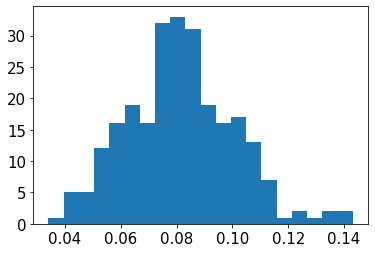

In [293]:
plt.hist(stats_df['IRBotT']['nanstd'], bins=20);

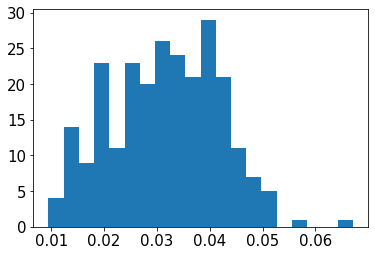

In [292]:
plt.hist(stats_df['Phase']['nanstd'], bins=20);

In [135]:
### Want to try a similar type of QC for Monte Carlo method using SNR

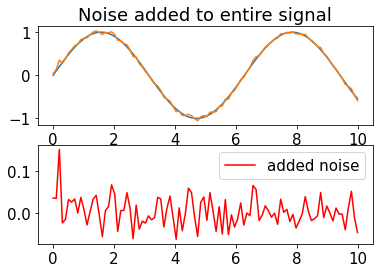

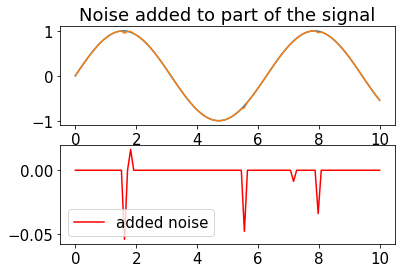

In [136]:
np.random.seed(137)
t = np.linspace(0, 10, 100)
p = np.sin(t)
percentage = 0.05
n = np.random.normal(0, p.std(), t.size) * percentage
pn = p + n

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.set_title('Noise added to entire signal')
ax1.plot(t, p, label='pure signal')
ax1.plot(t, pn, label='signal+noise')

ax2 = fig.add_subplot(212)
ax2.plot(t, pn - p, label='added noise', c='r')
plt.legend()

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.set_title('Noise added to part of the signal')
ax1.plot(t, p, label='pure signal')
random_indices = np.random.randint(0, t.size, int(t.size*percentage))

pr = p.copy()
pr[random_indices] += n[random_indices]
ax1.plot(t, pr, label='signal+noise')

ax2 = fig.add_subplot(212)
ax2.plot(t, pr - p, label='added noise', c='r')
plt.legend()
plt.show()

In [301]:
t = np.linspace(0, 48, 193)
p = np.linspace(220, 219, 193)

In [302]:
percentage = 0.4
n = np.random.normal(0, p.std(), t.size) * percentage

In [303]:
for i in range(10):
    n = np.random.normal(0, p.std(), t.size) * percentage
    if i == 0:
        data = p + n
    else:
        data = np.vstack([data, p+n])

In [304]:
nobs = len(p)

rates_arr = np.array([])
for i in range(0, 10000):
    rand_arr = np.random.randint(0,9 + 1, (nobs,))
    subsamp_oxy_ts = data[rand_arr, np.arange(nobs)]
    subsamp_oxy_time = t*60
    
    ps = np.polyfit(subsamp_oxy_time, 
                   subsamp_oxy_ts, deg=1)
    rates_arr = np.append(rates_arr, ps[0])

In [305]:
mu, sigma = np.mean(24*60*rates_arr.flatten()), np.std(24*60*rates_arr.flatten())
lc_t, uc_t = stats.norm.interval(0.95, loc=mu, scale=sigma)

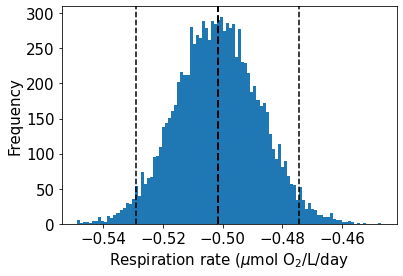

In [307]:
plt.hist(rates_arr*60*24, bins=100);
plt.xlabel(r'Respiration rate ($\mu$mol O$_2$/L/day')
plt.ylabel('Frequency')
plt.axvline(mu, color='black', linestyle='dashed', linewidth=2)
plt.axvline(lc_t, color='black', linestyle='dashed', linewidth=1.5)
plt.axvline(uc_t, color='black', linestyle='dashed', linewidth=1.5)
#plt.xlim(-2.3, -1.8)

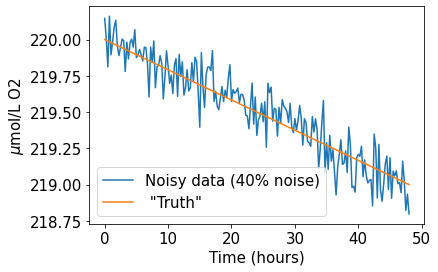

In [308]:
plt.plot(t, data[np.random.randint(0,9 + 1, (nobs,)), np.arange(nobs)], label='Noisy data (40% noise)')
plt.plot(t, p, label=' "Truth" ')
plt.xlabel('Time (hours)')
plt.ylabel(r'$\mu$mol/L O2')
plt.legend()

### Arbitrarily removing some data in the middle of the time period

In [270]:
data_missing = data.copy()
data_missing[:, 40:120] = np.nan

In [271]:
nobs = len(p)

rates_arr = np.array([])
for i in range(0, 10000):
    rand_arr = np.random.randint(0,9 + 1, (nobs,))
    subsamp_oxy_ts = data_missing[rand_arr, np.arange(nobs)]
    subsamp_oxy_time = t*60
    
    nan_ind = ~np.isnan(subsamp_oxy_ts)
    
    ps = np.polyfit(subsamp_oxy_time[nan_ind], 
                   subsamp_oxy_ts[nan_ind], deg=1)
    rates_arr = np.append(rates_arr, ps[0])

In [272]:
mu, sigma = np.mean(24*60*rates_arr.flatten()), np.std(24*60*rates_arr.flatten())
lc_t, uc_t = stats.norm.interval(0.95, loc=mu, scale=sigma)

(-2.3, -1.8)

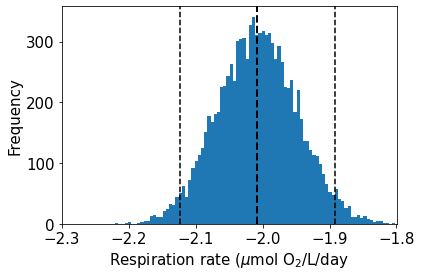

In [273]:
plt.hist(rates_arr*60*24, bins=100);
plt.xlabel(r'Respiration rate ($\mu$mol O$_2$/L/day')
plt.ylabel('Frequency')
plt.axvline(mu, color='black', linestyle='dashed', linewidth=2)
plt.axvline(lc_t, color='black', linestyle='dashed', linewidth=1.5)
plt.axvline(uc_t, color='black', linestyle='dashed', linewidth=1.5)
plt.xlim(-2.3, -1.8)

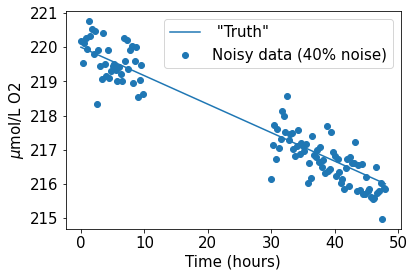

In [299]:
plt.plot(t, data_missing[np.random.randint(0,9 + 1, (nobs,)), np.arange(nobs)], label='Noisy data (40% noise)')
plt.plot(t, p, label=' "Truth" ')
plt.xlabel('Time (hours)')
plt.ylabel(r'$\mu$mol/L O2')
plt.legend()

In [358]:
temp_original_obs.shape

(1757,)

In [370]:
nan_ind.shape

(8476,)

In [364]:
full_arr = np.zeros(nan_ind.shape)
full_arr[:] = np.nan

In [366]:
full_arr[nan_ind] = temp_original_obs

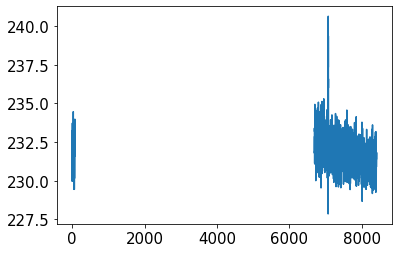

In [369]:
plt.plot(full_arr)

In [ ]:
### Want to get counts of monotonically increasing groups so we know how many observations the AutoBOD made

test_for_increasing = np.diff(oxy_sample) > 0
reps = np.array([ sum( 1 for _ in group ) for key, group in groupby( test_for_increasing )])
reps = reps[reps > 1]
reps[reps > 2] += 1
reps[reps <= 2] -= 1
tiled_temp = np.repeat(np.nanmean(oxy_temp_arr, axis=1), reps)

In [346]:
msmts = b_ds.measurement_number.values.flatten()[nan_ind]


In [347]:
msmts

array([ 12.,  12.,  12., ..., 151., 151., 151.])

In [348]:
np.array([ sum( 1 for _ in group ) for key, group in groupby( msmts )])

array([10, 10, 10, 10, 10, 10, 10,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10])

In [326]:
if len(oxy_sample) // n_msmts != nobs:
    print("Incomplete samples, padding with NaN")
    nobs = len([key for key, _group in groupby(b_ds.measurement_number.values.flatten()[nan_ind])])
    ### Pad the oxygen sample array with the number of "missing" observations
    try:
        oxy_sample_padded = np.pad(oxy_sample, (0, nobs*n_msmts - len(oxy_sample)))
    except ValueError:
        obs_list = [len(list(group)) for key, group in groupby(b_ds.measurement_number.values.flatten()[nan_ind])]
        nobs += np.sum(obs_list > n_msmts)
        oxy_sample_padded = np.pad(oxy_sample, (0, nobs*n_msmts - len(oxy_sample)))

    ### where does the expected array not match the actual sample array?
    expected_oxy_sample = np.tile(np.arange(1, n_msmts+1), nobs)
    mismatched_inds = np.argwhere(expected_oxy_sample != oxy_sample_padded)

    while len(mismatched_inds) > 0:
        oxy_sample = np.insert(oxy_sample, mismatched_inds[0], expected_oxy_sample[mismatched_inds[0]])
        oxy_temp = np.insert(oxy_temp, mismatched_inds[0], np.nan)

        #Recalculate amount of mismatch
        oxy_sample_padded = np.pad(oxy_sample, (0, nobs*n_msmts - len(oxy_sample)))
        mismatched_inds = np.argwhere(expected_oxy_sample != oxy_sample_padded)

Incomplete samples, padding with NaN


In [327]:
def calculate_nobs(ds, n_msmts=10):
    ### Calculate number of unique sets of N measurements
    nobs = len([key for key, _group in groupby(ds.measurement_number.values.flatten()[nan_ind])])
    ## Sometimes the measurement number gets repeated during the concatenation — if that's the case, double-check and add
    obs_list = np.array([len(list(group)) for key, group in groupby(ds.measurement_number.values.flatten()[nan_ind])])
    nobs += np.sum(obs_list > n_msmts) 
    return nobs

In [328]:
calculate_nobs(b_ds)

176

In [316]:
len(oxy_sample) % 10 

7

In [321]:
len(oxy_sample) // 10 != nobs

True

In [320]:
nobs

176

### Look at some plotted timeseries of oxygen concentration from different samples and do back-of-the envelope calculation of respiration rates 
Mostly to make sure code above works! Stay tuned for a bootstrapped approach to estimate respiration rates from all data poitns

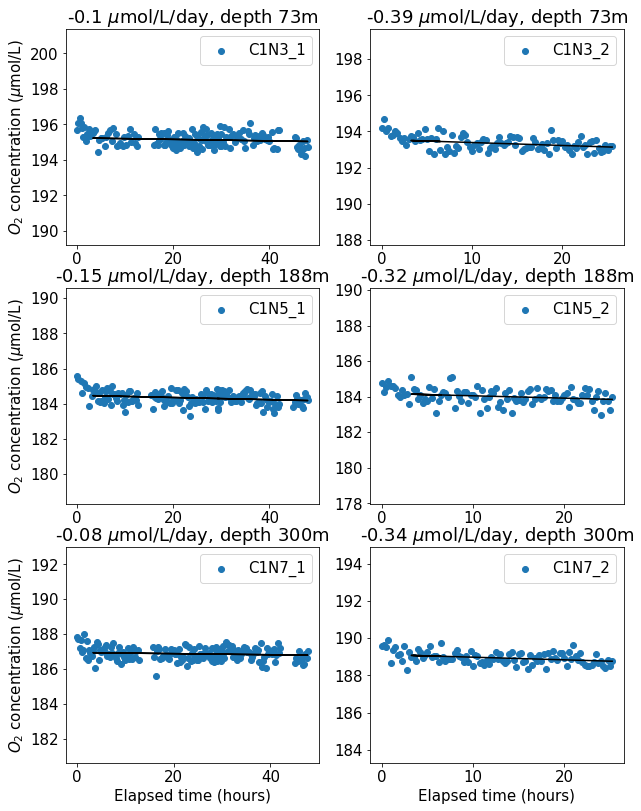

In [12]:
ids = ['C1N3', 'C1N5', 'C1N7']
    
fig, axes = plt.subplots(len(ids), 2, figsize = (10,4.5*len(ids)))

for j, val in enumerate(ids):
    
    for i in range(2):
        bid = val + '_' + str(i+1)
        test = master_ds.isel(N_bottles = master_ds.Bottle_ID == bid)
        test['time_float'] = test.UTC_datetime.astype('float')
        grpby = test.to_dataframe().groupby('measurement_number').agg({'O2_conc_umol_L': np.nanmedian,
                                            'IRBotT': np.nanmedian, 'time_float': np.nanmedian})

        axis_time = grpby.time_float.values - np.nanmin(grpby.time_float.values)
        axes[j, i].scatter(axis_time/(1e9*60*60), grpby.O2_conc_umol_L, label=bid)
        
        #Try to fit a polyline
        remove_outliers = True
        start_point = 3 #starting at 3 hours from collecting the bottle sample
        
        polyfit_resp_rates = []
        time_vals = axis_time/(1e9*60*60)
        time_ind = time_vals >= start_point
        time_vals = time_vals[time_ind]
        o2_vals = grpby.O2_conc_umol_L.values
        o2_vals = o2_vals[time_ind]
        nan_ind = ~np.isnan(o2_vals)

        #Remove outliers, i.e. with a zcore 
        if remove_outliers:
            outlier_ind = (np.abs(stats.zscore(o2_vals[nan_ind])) < 3)
        else:
            outlier_ind = np.ones(len(o2_vals[nan_ind])).astype('bool')
        p = np.polyfit(time_vals[nan_ind][outlier_ind], o2_vals[nan_ind][outlier_ind], deg=1)
        polyfit_resp_rates.append(p[0])
        #p = np.polyfit(time_vals[nan_ind], np.log(o2_vals)[nan_ind], deg=1)
        
        axes[j, i].plot(time_vals[nan_ind], p[0]*time_vals[nan_ind] + p[1], color='black')
        
        if j == len(ids) - 1:
            axes[j, i].set_xlabel('Elapsed time (hours)')
        if i == 0:
            axes[j, i].set_ylabel(r'$O_2$ concentration ($\mu$mol/L)')

        
        axes[j, i].set_ylim(np.nanmin(grpby.O2_conc_umol_L.values) - 5, 
                         np.nanmax(grpby.O2_conc_umol_L.values) + 5)

        axes[j, i].legend()
        
        axes[j, i].set_title(str(np.round(p[0]*24, 2)) + r' $\mu$mol/L/day' +\
                          ', depth '+ str(test.Depth.values[0]) + 'm')
        
        np.round(p[0]*24, 2)


In [73]:
master_ds

<xarray.Dataset>
Dimensions:               (N_bottles: 53, N_obs: 6606)
Coordinates:
    Bottle_ID             (N_bottles) object 'C10N18_1' 'C10N18_2' ... 'None_12'
Dimensions without coordinates: N_bottles, N_obs
Data variables: (12/20)
    Amplitude             (N_bottles, N_obs) float64 4.632e+03 4.644e+03 ... nan
    Phase                 (N_bottles, N_obs) float64 29.57 29.5 ... nan nan
    Optode_Calculated_O2  (N_bottles, N_obs) float64 1.573e+03 1.582e+03 ... nan
    Error                 (N_bottles, N_obs) float64 1.0 1.0 1.0 ... nan nan nan
    Encoder               (N_bottles, N_obs) float64 5.142e+04 5.142e+04 ... nan
    Bottle                (N_bottles, N_obs) float64 10.0 10.0 10.0 ... nan nan
    ...                    ...
    Elapsed_time_seconds  (N_bottles, N_obs) timedelta64[ns] 1 days 02:25:09 ...
    measurement_number    (N_bottles, N_obs) float64 9.0 9.0 9.0 ... nan nan nan
    UTC_datetime          (N_obs, N_bottles) datetime64[ns] 2022-02-22T20:13:...
    Depth                 (N_bottles) int64 40 40 40 50 ... 0 -9999 -9999 -9999
    Notes                 (N_bottles) object 'warm side of front' ... ' '
    Cast_Niskin           (N_bottles) object 'C10N18' 'C10N18' ... 'None' 'None'

In [286]:
b_ds = master_ds.isel(N_bottles = master_ds.Bottle_ID == 'C20N14_3')

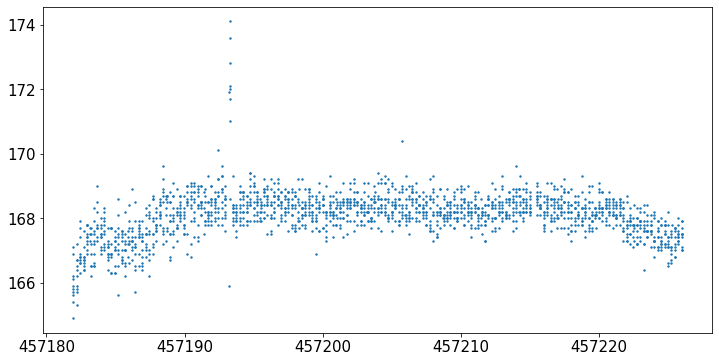

In [287]:
plt.figure(figsize=(12,6))
plt.scatter(b_ds.UTC_datetime.values.astype('float')/(1e9*60*60), b_ds.Optode_Calculated_O2.values[0]/10, s=2)


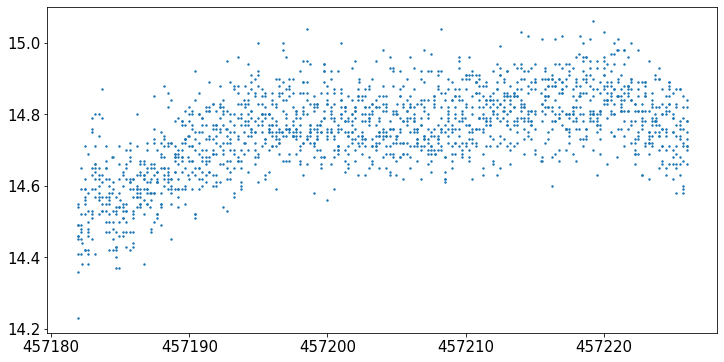

In [288]:
plt.figure(figsize=(12,6))
plt.scatter(b_ds.UTC_datetime.values.astype('float')/(1e9*60*60), b_ds.IRBotT, s=2)


In [289]:
empty_arr = np.empty((master_ds.dims['N_bottles'], master_ds.dims['N_obs']))
master_ds['test'] = (('N_bottles', 'N_obs'), empty_arr)

In [290]:
empty_arr = np.empty((master_ds.dims['N_bottles'], master_ds.dims['N_obs']))
master_ds['test'] = (('N_bottles', 'N_obs'), empty_arr)
master_ds.test.where(master_ds.Bottle_ID == 'C23N15_2')

<xarray.DataArray 'test' (N_bottles: 64, N_obs: 8476)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    Bottle_ID  (N_bottles) object 'C10N18_1' 'C10N18_2' ... 'None_10' 'None_12'
Dimensions without coordinates: N_bottles, N_obs

In [96]:
master_ds['test'] = xr.where(master_ds.test.Bottle_ID == 'C23N15_2', np.ones((1, 18692)), master_ds.test)

In [67]:
np.ones((1, 18692)).shape

(1, 18692)

In [60]:
empty_arr = np.empty((master_ds.dims['N_bottles'], master_ds.dims['N_obs']))

In [59]:
master_ds.dims['N_obs']

18692

In [291]:
nan_ind = ~np.isnan(b_ds.Sample.values.flatten())
oxy_sample = b_ds.Sample.values.flatten()[nan_ind]
oxy_temp = b_ds.IRBotT.values.flatten()[nan_ind]
oxy_phase = b_ds.Phase.values.flatten()[nan_ind]
oxy_time = b_ds.UTC_datetime.values.flatten()[nan_ind].astype('float')/(1e9*60) #in minutes

In [292]:
oxy_sample = b_ds.Sample.values.flatten()[nan_ind]
oxy_temp = b_ds.IRBotT.values.flatten()[nan_ind]
oxy_phase = b_ds.Phase.values.flatten()[nan_ind]
oxy_time = b_ds.UTC_datetime.values.flatten()[nan_ind].astype('float')/(1e9*60) #in minutes

In [293]:
if len(oxy_sample) % 10 != 0:
    print("Incomplete samples, padding with NaN")
    nobs = len([key for key, _group in groupby(b_ds.measurement_number.values.flatten()[nan_ind])])
    ### Pad the oxygen sample array with the number of "missing" observations
    try:
        oxy_sample_padded = np.pad(oxy_sample, (0, nobs*10 - len(oxy_sample)))
    except ValueError:
        obs_list = [len(list(group)) for key, group in groupby(b_ds.measurement_number.values.flatten()[nan_ind])]
        nobs += np.sum(obs_list > 10)
        oxy_sample_padded = np.pad(oxy_sample, (0, nobs*10 - len(oxy_sample)))

    ### where does the expected array not match the actual sample array?
    expected_oxy_sample = np.tile(np.arange(1, 11), nobs)
    mismatched_inds = np.argwhere(expected_oxy_sample != oxy_sample_padded)

    while len(mismatched_inds) > 0:
        oxy_sample = np.insert(oxy_sample, mismatched_inds[0], expected_oxy_sample[mismatched_inds[0]])
        oxy_temp = np.insert(oxy_temp, mismatched_inds[0], np.nan)

        #Recalculate amount of mismatch
        oxy_sample_padded = np.pad(oxy_sample, (0, nobs*10 - len(oxy_sample)))
        mismatched_inds = np.argwhere(expected_oxy_sample != oxy_sample_padded)

Incomplete samples, padding with NaN


In [294]:
sample_number_arr = np.reshape(oxy_sample, (len(oxy_sample)//10, 10))
print(np.sum(np.diff(sample_number_arr, axis=0)) == 0)

oxy_temp_arr = np.reshape(oxy_temp, (len(oxy_temp)//10, 10))
nobs = len(oxy_temp_arr)

True


In [295]:
oxy_sample = b_ds.Sample.values.flatten()[nan_ind]
oxy_temp = b_ds.IRBotT.values.flatten()[nan_ind]

In [296]:
test_for_increasing = np.diff(oxy_sample) > 0
reps = np.array([ sum( 1 for _ in group ) for key, group in groupby( test_for_increasing )])
reps = reps[reps > 1]
reps[reps > 2] += 1
reps[reps <= 2] -= 1
tiled_temp = np.repeat(np.nanmean(oxy_temp_arr, axis=1), reps)

(225.0, 240.0)

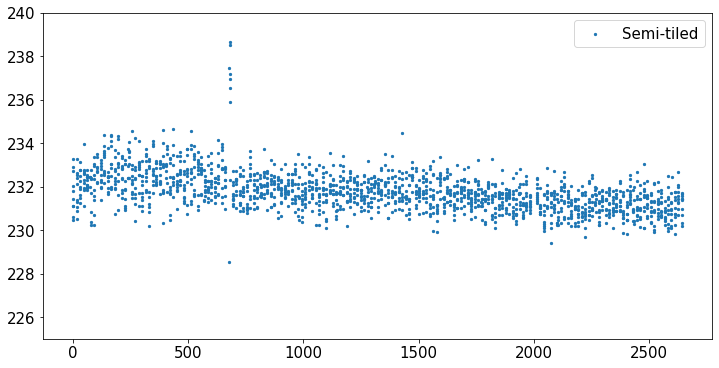

In [307]:
plt.figure(figsize=(12,6))
# plt.scatter(oxy_time - np.nanmin(oxy_time), 
#          calc_o2_conc(calc_airsat(oxy_phase, tiled_temp), tiled_temp, 38.4), label='All tiled', s=5)
plt.scatter(oxy_time - np.nanmin(oxy_time), 
            calc_o2_conc(calc_airsat(oxy_phase, oxy_temp), tiled_temp, 38.4), label='Semi-tiled', s=5)
# plt.scatter(oxy_time - np.nanmin(oxy_time), calc_o2_conc(calc_airsat(oxy_phase, oxy_temp), oxy_temp, 38.4), 
#           label='No tile', color='green', s=5)
plt.legend()
plt.ylim([225, 240])

In [248]:
test_for_consecutive = oxy_sample[1:] == oxy_sample[:-1] + 1
reps = np.array([ sum( 1 for _ in group ) for key, group in groupby( test_for_consecutive ) if key])
# reps = reps[reps > 1]
# reps[reps >= 9] += 1
# reps[reps <= 2] -= 1
tiled_temp = np.repeat(np.nanmean(oxy_temp_arr, axis=1), reps)

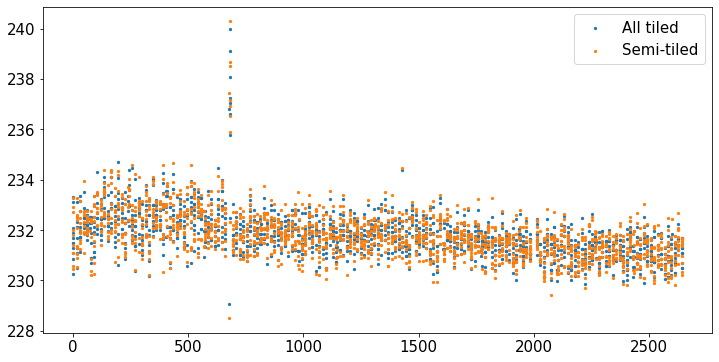

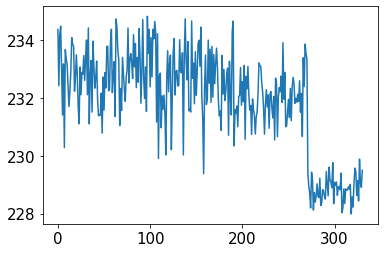

In [217]:
plt.plot(calc_o2_conc(calc_airsat(oxy_phase, oxy_temp), tiled_temp, 38))

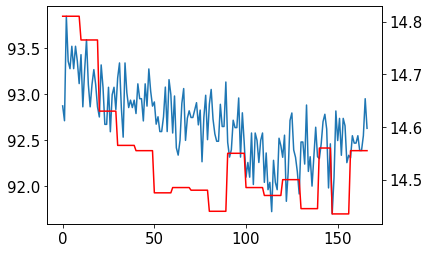

In [92]:
plt.plot(calc_airsat(oxy_phase, tiled_temp))
plt.gca().twinx()
plt.plot(tiled_temp, color='red')

In [74]:
tiled_temp.shape

(170,)

In [86]:
[ sum( 1 for _ in group ) +1 for key, group in groupby( xx ) if key ]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 10, 10]

In [83]:
xx = oxy_sample[1:] == oxy_sample[:-1] + 1

In [80]:
oxy_sample - 1

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3.,
       4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0.,
       1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7.,
       8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4.,
       5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1.,
       2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8.,
       9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5.,
       6., 7., 8., 9., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3., 4., 5.,
       6., 7., 8., 9., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [75]:
reps

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [114]:
oxy_sample = b_ds.Sample.values.flatten()[nan_ind]
oxy_temp = b_ds.Sample.values.flatten()[nan_ind]

In [131]:
reps.astype('int')

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10])

In [138]:
reps = oxy_sample[np.diff(oxy_sample, append=0) < 1].astype('int')
tiled_temp = np.repeat(np.nanmedian(oxy_temp_arr, axis=1), reps)

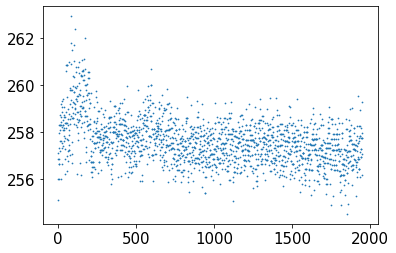

In [148]:
plt.scatter(np.arange(1950), calc_airsat_o2_conc(oxy_phase, tiled_temp, 0)[1], s=0.5)

calc_o2_conc

In [121]:
np.diff(oxy_sample, append=0)

array([  1.,   1.,   1., ...,   1.,   1., -10.])

In [124]:
np.nanmedian(oxy_temp_arr, axis=1).shape

(195,)

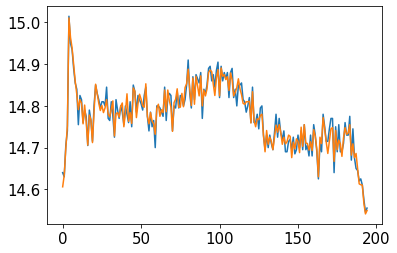

In [113]:
plt.plot(np.nanmedian(oxy_temp_arr, axis=1))
plt.plot(np.nanmean(oxy_temp_arr, axis=1))

In [ ]:


mean_rates = []

for j, val in enumerate(ids):
    
    for i in range(3):
        bid = val + '_' + str(i+1)
        b_ds = resp_ds.isel(N_bottles = resp_ds.Bottle_ID == bid)
        nan_ind = ~np.isnan(b_ds.Sample.values.flatten())
        oxy_ts = b_ds.O2_conc_umol_L.values.flatten()[nan_ind]
        oxy_time = b_ds.UTC_datetime.values.flatten()[nan_ind].astype('float')/(1e9*60) #in minutes
        oxy_sample = b_ds.Sample.values.flatten()[nan_ind]
        
        ### First, check if the number of NaN measurements is divisible by 10
        if len(oxy_sample) % 10 != 0:
            print("Incomplete samples, padding with NaN")
            nobs = len([key for key, _group in groupby(b_ds.measurement_number.values.flatten()[nan_ind])])
            ### Pad the oxygen sample array with the number of "missing" observations
            try:
                oxy_sample_padded = np.pad(oxy_sample, (0, nobs*10 - len(oxy_sample)))
            except ValueError:
                obs_list = np.argwhere([len(list(group)) for key, group in groupby(b_ds.measurement_number.values.flatten()[nan_ind])])
                nobs += np.sum(obs_list > 10)
                oxy_sample_padded = np.pad(oxy_sample, (0, nobs*10 - len(oxy_sample)))
                    
            ### where does the expected array not match the actual sample array?
            expected_oxy_sample = np.tile(np.arange(1, 11), nobs)
            mismatched_inds = np.argwhere(expected_oxy_sample != oxy_sample_padded)
            
            while len(mismatched_inds) > 0:
                oxy_sample = np.insert(oxy_sample, mismatched_inds[0], expected_oxy_sample[mismatched_inds[0]])
                oxy_time = np.insert(oxy_time, mismatched_inds[0], np.nan)
                oxy_ts = np.insert(oxy_ts, mismatched_inds[0], np.nan)

                #Recalculate amount of mismatch
                oxy_sample_padded = np.pad(oxy_sample, (0, nobs*10 - len(oxy_sample)))
                mismatched_inds = np.argwhere(expected_oxy_sample != oxy_sample_padded)
        
        sample_number_arr = np.reshape(oxy_sample, (len(oxy_sample)//10, 10))
        print(np.sum(np.diff(sample_number_arr, axis=0)) == 0)
        oxy_ts_arr = np.reshape(oxy_ts, (len(oxy_ts)//10, 10))
        oxy_time_arr = np.reshape(oxy_time, (len(oxy_time)//10, 10))
        nobs = len(oxy_ts_arr)
        rates_arr = np.array([])
        for i in range(0, 10000):
            rand_arr = random.randint(0,9 + 1, (nobs,))
            subsamp_oxy_ts = oxy_ts_arr[np.arange(nobs), rand_arr]
            subsamp_oxy_time = oxy_time_arr[np.arange(nobs), rand_arr]
            subsamp_nan_ind = ~np.isnan(subsamp_oxy_ts) #we have now introduced NaN into randomly sampled ts
            p = np.polyfit(subsamp_oxy_time[subsamp_nan_ind], subsamp_oxy_ts[subsamp_nan_ind], deg=1)
            rates_arr = np.append(rates_arr, p[0])
        
        mu, sigma = np.mean(rates_arr*24*60), np.std(rates_arr*24*60)
        mean_rates.append(mu)

In [40]:
test

<xarray.Dataset>
Dimensions:               (N_bottles: 1, N_obs: 18692)
Coordinates:
    Bottle_ID             (N_bottles) object 'C23N15_2'
Dimensions without coordinates: N_bottles, N_obs
Data variables: (12/20)
    Amplitude             (N_bottles, N_obs) float64 2.926e+03 2.932e+03 ... nan
    Phase                 (N_bottles, N_obs) float64 30.45 30.53 ... nan nan
    Optode_Calculated_O2  (N_bottles, N_obs) float64 1.458e+03 1.448e+03 ... nan
    Error                 (N_bottles, N_obs) float64 5.0 5.0 5.0 ... nan nan nan
    Encoder               (N_bottles, N_obs) float64 4.046e+04 4.046e+04 ... nan
    Bottle                (N_bottles, N_obs) float64 8.0 8.0 8.0 ... nan nan nan
    ...                    ...
    Elapsed_time_seconds  (N_bottles, N_obs) timedelta64[ns] 00:52:56 ... NaT
    measurement_number    (N_bottles, N_obs) float64 11.0 11.0 11.0 ... nan nan
    UTC_datetime          (N_obs, N_bottles) datetime64[ns] 2022-02-26T18:02:...
    Depth                 (N_bottles) int64 100
    Notes                 (N_bottles) object ' '
    Cast_Niskin           (N_bottles) object 'C23N15'

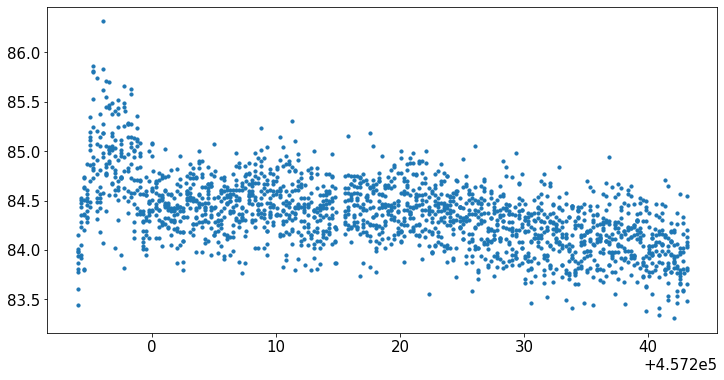

In [39]:
plt.figure(figsize=(12,6))
plt.scatter(test.UTC_datetime.values.astype('float')/(1e9*60*60), 
            calc_airsat_o2_conc(test.Phase.values[0], test.IRBotT, 0)[0], s=10)
#plt.ylim(147.5, 154.5)

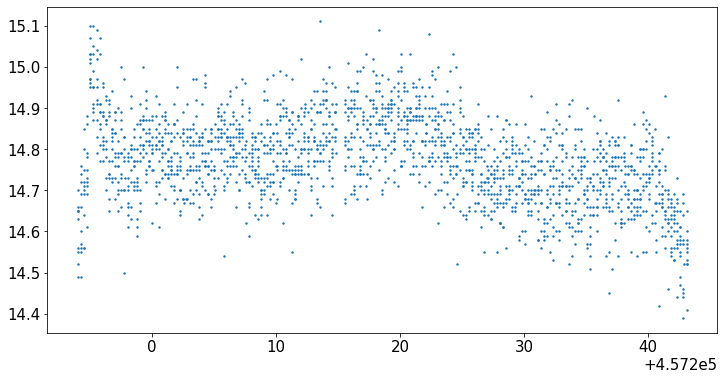

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(test.UTC_datetime.values.astype('float')/(1e9*60*60), 
            test.IRBotT.values, s=2)
#plt.ylim(147.5, 154.5)

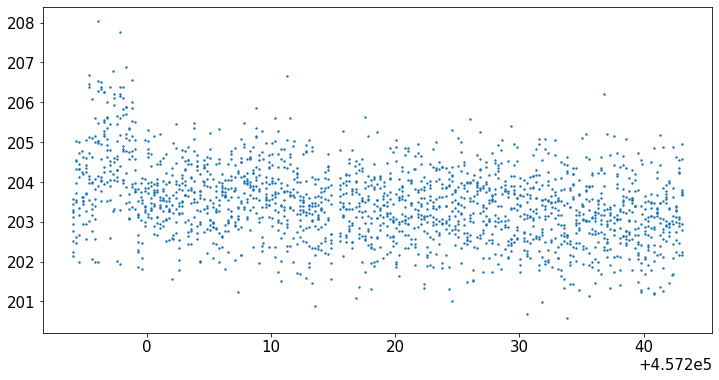

In [356]:
plt.figure(figsize=(12,6))
plt.scatter(test.UTC_datetime.values.astype('float')/(1e9*60*60), test.O2_conc_umol_L.values[0], s=2)


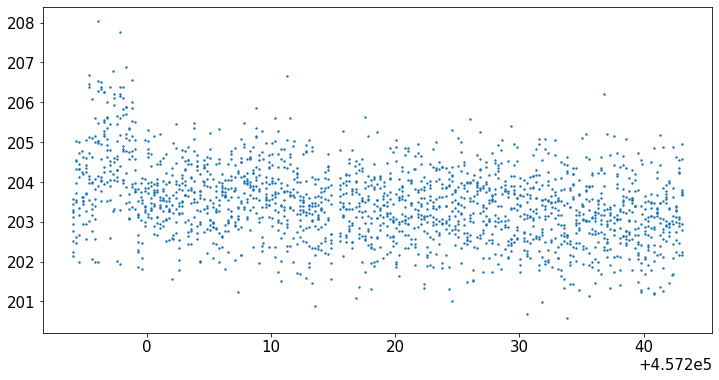

In [359]:
plt.figure(figsize=(12,6))
plt.scatter(test.UTC_datetime.values.astype('float')/(1e9*60*60), test.O2_conc_umol_L.values[0], s=2)


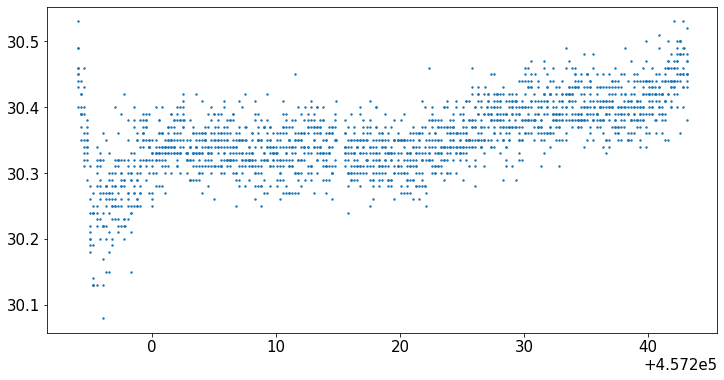

In [360]:
plt.figure(figsize=(12,6))
plt.scatter(test.UTC_datetime.values.astype('float')/(1e9*60*60), test.Phase.values[0], s=2)
#plt.xlim(69, 80)

In [44]:
test

<xarray.Dataset>
Dimensions:               (N_bottles: 1, N_obs: 18692)
Coordinates:
    Bottle_ID             (N_bottles) object 'C23N15_1'
Dimensions without coordinates: N_bottles, N_obs
Data variables: (12/21)
    Amplitude             (N_bottles, N_obs) float64 2.434e+03 2.433e+03 ... nan
    Phase                 (N_bottles, N_obs) float64 30.12 30.13 ... nan nan
    Optode_Calculated_O2  (N_bottles, N_obs) float64 1.502e+03 1.5e+03 ... nan
    Error                 (N_bottles, N_obs) float64 5.0 5.0 5.0 ... nan nan nan
    Encoder               (N_bottles, N_obs) float64 7.792e+03 7.792e+03 ... nan
    Bottle                (N_bottles, N_obs) float64 2.0 2.0 2.0 ... nan nan nan
    ...                    ...
    O2_conc_umol_L        (N_bottles, N_obs) float64 208.4 208.1 ... nan nan
    measurement_number    (N_bottles, N_obs) float64 2.0 2.0 2.0 ... nan nan nan
    UTC_datetime          (N_obs, N_bottles) datetime64[ns] 2022-02-26T17:11:...
    Depth                 (N_bottles) int64 100
    Notes                 (N_bottles) object ' '
    Cast_Niskin           (N_bottles) object 'C23N15'

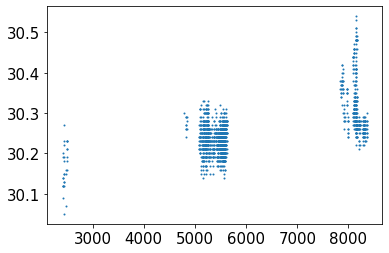

In [85]:
plt.scatter(test.Amplitude.values[0], test.Phase.values[0], s=1)

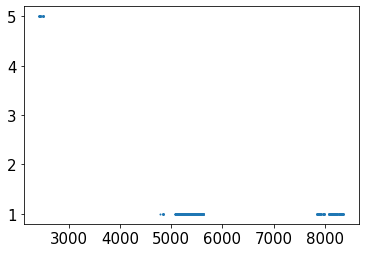

In [96]:
plt.scatter(test.Amplitude.values[0], test.Error.values[0], s=1)

In [8]:
log_files = glob.glob(log_dir+'*.log')
log_files;

In [9]:
log_files[5]

'../logs/AutoBOD_logs/Run051_030822_autoBOD.log'

In [10]:
cols = ['Amplitude', 'Phase', 'Optode_Calculated_O2', 'Error', 'Encoder', 'Bottle', 'Sample', 
    'Date', 'Hour', 'IRDetT', 'IRBotT', 'Steps', 'Light']
run = pd.read_csv(log_files[5], skiprows=4, skipfooter=3, names = cols,
            sep='\s+', engine='python')

In [11]:
df = run[run['Error'] == 1]

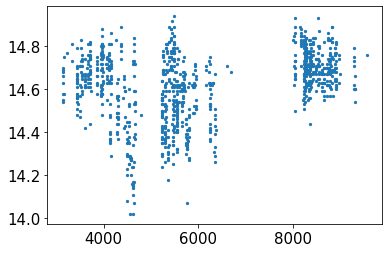

In [12]:
plt.scatter(df.Amplitude.values, df.IRBotT.values, s=5)

In [427]:
# def calc_airsat_o2_conc(phase, IRBotT, Sal):
    
#     from numpy import tan, pi, sqrt, exp, log
    
#     #Defining constants 
#     cal0 = 60.21 #B6
#     cal100 = 27.42 #B7
#     airpres = 981 #B8
#     T0 = 20 #E6
#     T100 = 20 #E7
#     dF_k = -0.0847 #B12
#     f1 = 0.833 #B11
#     dksv_k = 0.000416 #B13
#     m = 34 #B14
    
#     #Salinity-related corrections
#     # http://www.argodatamgt.org/content/download/26531/181223/file/Aanderaa_TD218_OperatingManual_OxygenOptode_3830_3835_3930_3975_4130_4175_RevApr2007.pdf
#     Ts_eq = lambda t: np.log((298.15 - t)/(273.15 + t)) #scaled temperature, depends on temperature of incubation
#     B0 = -6.24097e-3
#     C0 = -3.1168e-7
#     B1 = -6.93498e-3
#     B2= -6.90358e-3
#     B3 = -4.29155e-3
    
#     tan_psi0_t100 = tan(((cal0+dF_k*(T100-T0)))*pi/180) #D11
#     tan_psi100_t100 = tan(cal100*pi/180) #D13

#     A = tan_psi100_t100/tan_psi0_t100*1/m*100**2 #F11
#     B = tan_psi100_t100/tan_psi0_t100*100+tan_psi100_t100/tan_psi0_t100*100/m-f1*100/m-100+f1*100 #F12
#     C = tan_psi100_t100/tan_psi0_t100-1 #F13

#     ksv_t100 = (-B+sqrt(B**2-4*A*C))/(2*A) #H11
    
#     air_sat = (-((tan(phase*pi/180))/(tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*
#                         (ksv_t100+(dksv_k*(IRBotT-T100)))+(tan(phase*pi/180))/
#                         (tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*1/m*(ksv_t100+(dksv_k
#                         *(IRBotT-T100)))-f1*1/m*(ksv_t100+(dksv_k*(IRBotT-T100)))-(ksv_t100
#                         +(dksv_k*(IRBotT-T100)))+f1*(ksv_t100+(dksv_k*(IRBotT-T100))))+(
#                         sqrt(((((tan(phase*pi/180))/(tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*(
#                         ksv_t100+(dksv_k*(IRBotT-T100)))+(tan(phase*pi/180))/(tan((cal0+(dF_k*(
#                         IRBotT-T0)))*pi/180))*1/m*(ksv_t100+(dksv_k*(IRBotT-T100)))-
#                         f1*1/m*(ksv_t100+(dksv_k*(IRBotT-T100)))-(ksv_t100+(dksv_k*
#                         (IRBotT-T100)))+f1*(ksv_t100+(dksv_k*(IRBotT-T100))))**2))-
#                         4*((tan(phase*pi/180))/(tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*1/m*
#                         ((ksv_t100+(dksv_k*(IRBotT-T100)))**2))*((tan(phase*pi/180))/(
#                         tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))-1))))/(2*((tan(phase*pi/180))/
#                         (tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*1/m*((ksv_t100+(dksv_k*(IRBotT-T100)))**2)))


#     o2_conc = (((airpres-exp(52.57-6690.9/(273.15+IRBotT)-4.681*log(273.15+IRBotT)))/1013)*
#            air_sat/100.*0.2095*(48.998-1.335*IRBotT+0.02755*IRBotT**2-
#                                  0.000322*IRBotT**3+0.000001598*IRBotT**4)*32/22.414)
    
#     #Salinity correction
#     Ts = Ts_eq(IRBotT)
#     o2_conc*=np.exp(Sal*(B0 + B1*Ts+ B2*Ts**2 + B3*Ts**3) + C0*Sal**2)
    
#     o2_conc *= 31.25 #umol/L
    
#     return o2_conc

In [95]:
df_b = df[df['Bottle'] == 11]

In [97]:
df_b

,Amplitude,Phase,Optode_Calculated_O2,Error,Encoder,Bottle,Sample,Date,Hour,IRDetT,IRBotT,Steps,Light
49,8219,3158,1330,1,56880,11,1,01/07/22,05:11:12,15.49,14.55,4,0
50,8226,3154,1334,1,56880,11,2,01/07/22,05:11:15,15.48,14.81,4,1
51,8234,3154,1334,1,56880,11,3,01/07/22,05:11:18,15.49,14.61,4,0
52,8242,3154,1334,1,56880,11,4,01/07/22,05:11:21,15.47,14.82,4,46
53,8320,3155,1334,1,56880,11,5,01/07/22,05:11:24,15.49,14.55,4,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,8173,3151,1338,1,56928,11,6,01/07/22,06:56:30,15.49,14.85,5,1
885,8172,3152,1337,1,56928,11,7,01/07/22,06:56:33,15.48,14.83,5,0
886,8176,3153,1335,1,56928,11,8,01/07/22,06:56:36,15.49,14.82,5,0
887,8176,3152,1337,1,56928,11,9,01/07/22,06:56:39,15.49,14.85,5,0


In [98]:
df_b['measurement_number'] = ((df_b['Sample'] - df_b['Sample'].shift(1)) < 0).cumsum() + 1

/Users/katyabbott/miniconda3/envs/argo/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [113]:
xx = df_b.groupby('measurement_number').aggregate({'IRBotT': 'median'})

In [114]:
fake_t = np.tile(xx, 10).flatten()[:]

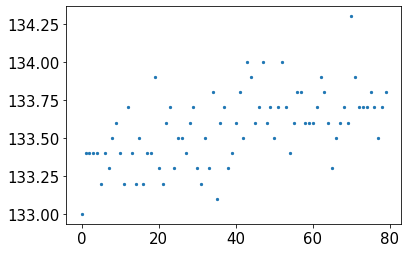

In [115]:
plt.scatter(np.arange(df_b.shape[0]), df_b.Optode_Calculated_O2/10, s=5)

In [116]:
air_sat, o2_conc = calc_airsat_o2_conc(df_b.Phase.values/100, df_b.IRBotT, 0)

In [117]:
o2_conc1 = (((airpres-np.exp(52.57-6690.9/(273.15+fake_t)-4.681*np.log(273.15+fake_t)))/1013)*
            air_sat/100.*0.2095*(48.998-1.335*fake_t+0.02755*fake_t**2-
                                  0.000322*fake_t**3+0.000001598*fake_t**4)*32/22.414)

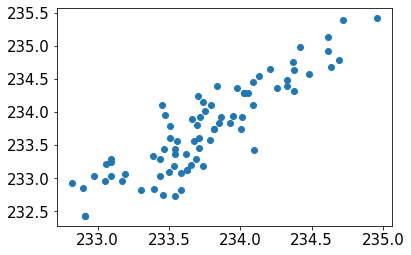

In [118]:
plt.scatter(o2_conc1*31.25, o2_conc)

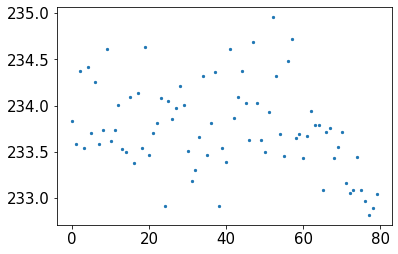

In [119]:
plt.scatter(np.arange(df_b.shape[0]), o2_conc1*31.25, s=5)
#plt.ylim(246, 251)

In [120]:
airpres = 981

### Big idea here is to calculate the oxygen concentration from the air saturated oxygen percentage using a standard averaged (or median?) temperature from the 10 observations per AutoBOD run. 
It might make sense to me to use the temperature from the AutoBOD (IRBotT) to calculate the air_sat quantity from the phase because I feel like that must take into account how the optode responds at different temperatures. But it definitely feels weird to use different bottle temperatures to go from that to the oxygen concentration, because that's a straightforward chemical formula that takes you from the saturation state of oxygen (I think percent saturation actually) to concentration based on temperature. So since we know a bottle has the same temperature throughout, if we know the percent saturation then it doesn't make sense to pretend it has different temperatures and therefore very different oxygen concentrations throughout the observation period. After all, what we are really asking is how the oxygen concentration is changing with time. The only questions I have are about whether to take the median or mean for temperature (I think maybe median??) and also whether I should be using all the variable bottle temperatures for the air_sat calculation or starting from an average value even then. Might be worth asking Paul or Amala.

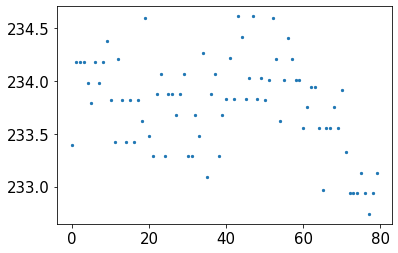

In [121]:
plt.scatter(np.arange(df_b.shape[0]), calc_airsat_o2_conc(df_b.Phase.values/100, fake_t, 0)[1], s=5)
#plt.ylim(246, 251)

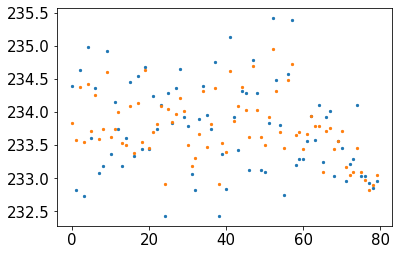

In [122]:
plt.scatter(np.arange(df_b.shape[0]), o2_conc, s=5)
plt.scatter(np.arange(df_b.shape[0]), o2_conc1*31.25, s=5)

In [24]:
df_b

,Amplitude,Phase,Optode_Calculated_O2,Error,Encoder,Bottle,Sample,Date,Hour,IRDetT,IRBotT,Steps,Light,measurement_number
0,5363,3101,1397,1,23904,5,2,01/07/22,05:04:45,15.53,14.31,2,0,1
1,5366,3103,1395,1,23904,5,3,01/07/22,05:04:48,15.51,14.30,2,1,1
2,5366,3110,1386,1,23904,5,4,01/07/22,05:04:51,15.52,14.28,2,0,1
3,5365,3099,1399,1,23904,5,5,01/07/22,05:04:54,15.53,14.38,2,0,1
4,5374,3105,1393,1,23904,5,6,01/07/22,05:04:57,15.53,14.34,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,5457,3089,1412,1,23968,5,6,01/07/22,07:04:57,15.49,14.79,3,52,9
945,5461,3084,1419,1,23968,5,7,01/07/22,07:05:00,15.47,14.55,3,11,9
946,5459,3088,1413,1,23968,5,8,01/07/22,07:05:03,15.47,14.41,3,3,9
947,5461,3094,1406,1,23968,5,9,01/07/22,07:05:06,15.47,14.59,3,7,9


In [444]:
df_b

,Amplitude,Phase,Optode_Calculated_O2,Error,Encoder,Bottle,Sample,Date,Hour,IRDetT,IRBotT,Steps,Light,measurement_number
0,5363,3101,1397,1,23904,5,2,01/07/22,05:04:45,15.53,14.31,2,0,1
1,5366,3103,1395,1,23904,5,3,01/07/22,05:04:48,15.51,14.30,2,1,1
2,5366,3110,1386,1,23904,5,4,01/07/22,05:04:51,15.52,14.28,2,0,1
3,5365,3099,1399,1,23904,5,5,01/07/22,05:04:54,15.53,14.38,2,0,1
4,5374,3105,1393,1,23904,5,6,01/07/22,05:04:57,15.53,14.34,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,5457,3089,1412,1,23968,5,6,01/07/22,07:04:57,15.49,14.79,3,52,9
945,5461,3084,1419,1,23968,5,7,01/07/22,07:05:00,15.47,14.55,3,11,9
946,5459,3088,1413,1,23968,5,8,01/07/22,07:05:03,15.47,14.41,3,3,9
947,5461,3094,1406,1,23968,5,9,01/07/22,07:05:06,15.47,14.59,3,7,9


(246.0, 251.0)

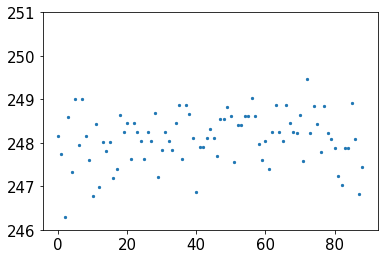

In [469]:
plt.scatter(np.arange(df_b.shape[0]), calc_airsat_o2_conc(df_b.Phase.values/100, fake_t, 0), s=5)
plt.ylim(246, 251)

In [437]:
cols = ['Amplitude', 'Phase', 'AirTemp', 'Oxygen', 'Error', 'Encoder', 
        'Bottle', 'Sample', 'Date', 'Hour', 'IRdetT', 'IRBotT']
run = pd.read_csv('../../20190405_run13.log', skiprows=5, skipfooter=3, names = cols,
            sep='\s+', engine='python')
df = run[run['Error'] == 0]

In [318]:
df_b = df[df['Bottle'] == 9]

AttributeError: 'DataFrame' object has no attribute 'IrBotT'

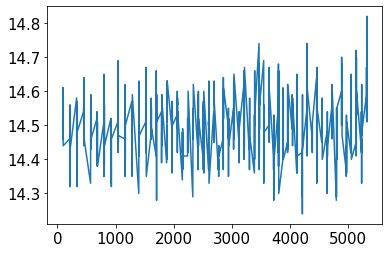

In [288]:
plt.plot(df_b.IRBotT)

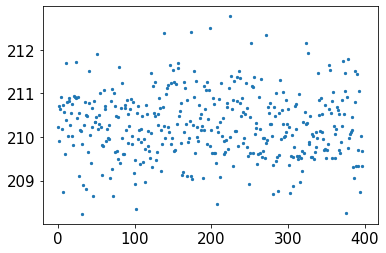

In [320]:
plt.scatter(np.arange(df_b.shape[0]), calc_airsat_o2_conc(df_b.Phase.values/100, df_b.IRBotT, 38.4), s=5)

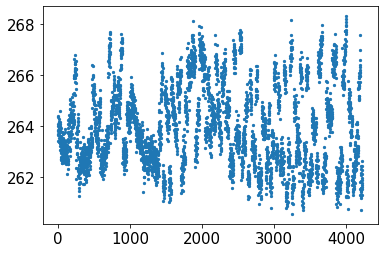

In [265]:
plt.scatter(np.arange(df_b.shape[0]), df_b.Oxygen.values/1000, s=5)

In [326]:
df_b['measurement_number'] = ((df_b['Sample'] - df_b['Sample'].shift(1)) < 0).cumsum() + 1

/Users/katyabbott/miniconda3/envs/argo/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [327]:
yy = df_b.groupby('measurement_number').aggregate({'IRBotT': 'mean'})

In [373]:
xx = df_b.groupby('measurement_number').aggregate({'Phase': 'mean'})
zz = df_b.groupby('measurement_number').aggregate({'Optode_Calculated_O2': 'mean'})

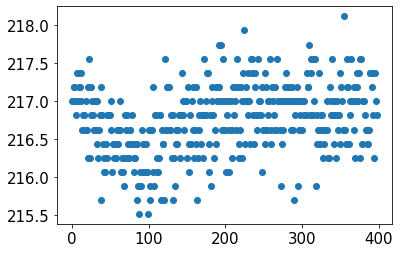

In [376]:
plt.scatter(np.arange(0, df_b.shape[0]), calc_airsat_o2_conc(df_b.Phase/100, 20, 0))

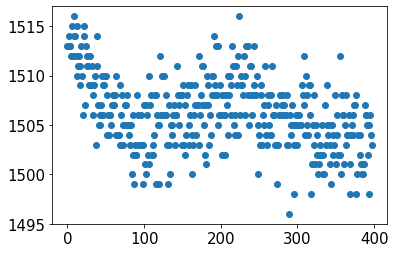

In [374]:
plt.scatter(np.arange(0, df_b.shape[0]), df_b.Optode_Calculated_O2.values)

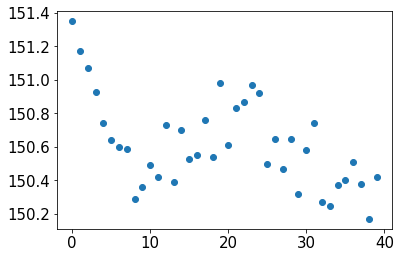

In [367]:
plt.scatter(np.arange(0, zz.shape[0]), zz/10)

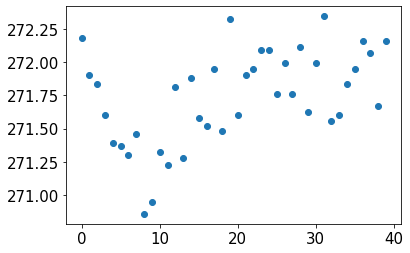

In [369]:
plt.scatter(np.arange(0, zz.shape[0]), calc_airsat_o2_conc(xx.values.flatten()/100, 14, 0))

,Phase
measurement_number,
1,3054.1
2,3053.8
3,3055.4
4,3051.8
5,3054.3
6,3055.3
7,3055.1
8,3055.4
9,3054.5


In [204]:
df_b

,Amplitude,Phase,Optode_Calculated_O2,Error,Encoder,Bottle,Sample,Date,Hour,IRDetT,IRBotT,Steps,Light,measurement_number
100,5021,2990,1535,1,56544,11,1,01/01/22,00:11:59,15.14,14.39,1,0,1
101,5024,2994,1530,1,56544,11,2,01/01/22,00:12:02,15.17,14.46,1,0,1
102,5031,2993,1531,1,56544,11,3,01/01/22,00:12:05,15.14,14.52,1,1,1
103,5028,2987,1540,1,56544,11,4,01/01/22,00:12:08,15.16,14.52,1,0,1
104,5034,2992,1533,1,56544,11,5,01/01/22,00:12:11,15.18,14.70,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5335,5155,2987,1531,1,56656,11,6,01/01/22,14:11:34,15.30,14.54,2,0,55
5336,5165,2988,1529,1,56672,11,7,01/01/22,14:11:37,15.31,14.55,2,1,55
5337,5130,2991,1525,1,56672,11,8,01/01/22,14:11:40,15.31,14.71,2,0,55
5338,5169,2991,1525,1,56656,11,9,01/01/22,14:11:43,15.31,14.66,2,1,55


In [183]:
df_b.IRBotT

100     14.39
101     14.46
102     14.52
103     14.52
104     14.70
        ...  
5335    14.54
5336    14.55
5337    14.71
5338    14.66
5339    14.62
Name: IRBotT, Length: 536, dtype: float64

In [148]:
df_b.shape[0]

357